# Tabular Playground Series - November 2021

In this notebook, we explore the dataset as well as perform some preprocessing that will speed up our analyses later on by reducing the memory usage and using a better format for saving the data. In particular, we will do the following in this notebook:

1. Reduce memory and save in a .feather format 
2. Adversarial Validation
3. Exploratory Data Analysis
4. Baseline

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, mean_squared_error

# Models
import xgboost as xgb
from xgboost import XGBClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Reduce Memory and Feather

In this section we reduce the amount of memory needed to store the training and test data by downcasting the variables to a lower datatype (e.g. float64 to float32). We also save our new data in a `.feather` format which will preserve our new datatypes as well as allow us to load the data much quicker

In [3]:
# Print the paths to all of the original files
for dirname, _, filenames in os.walk('..\data'):
    for filename in filenames:
        if filename.endswith('.csv'):
            print(os.path.join(dirname, filename))

..\data\sample_submission.csv
..\data\test.csv
..\data\train.csv


In [4]:
%%time

# Load original .csv data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Save feature columns names for later
features = [x for x in train.columns if x not in ['id', 'target']]

Wall time: 9.73 s


## 1.1 Memory Reduction

In [5]:
# Downcast float/int datatypes
def reduce_memory_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
        
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [6]:
%%time

# Reduce memory and save as .feather
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Mem. usage decreased to 231.74 Mb (50.4% reduction)
Mem. usage decreased to 208.05 Mb (50.0% reduction)
Wall time: 12.8 s


We see that we were able to downcast each float64 to float32 as well as downcasting the `target` and `id` columns, which roughly halves the memory usage.

## 1.2 Feather Format

In [7]:
# Save data as .feather format
train.to_feather('../data/train.feather')
test.to_feather('../data/test.feather')

del train, test

In [8]:
%%time

# Reload data
train = pd.read_feather('../data/train.feather')
test = pd.read_feather('../data/test.feather')

Wall time: 588 ms


By using `.feather` we are able to load our data much quicker and also preserve the new datatypes.

# 2. Adversarial Validation

The idea behind adversarial validation is that if there are differences in the training and test data distributions a machine learning algorithm should be able to find these differences and use them to distinguish the two sets. 

So we create a classification problem where we predict whether a sampling of the data comes from the training or test sets. Ideally, we hope to see ~.5 AUC which would mean that our algorithm couldn't find meaningful distinctions between the test and training data.

In [9]:
# Performs adversarial validation with a scikit-learn compatible model
def adversarial_validation(train, test, sklearn_model):
    
    scores = np.zeros(NUM_FOLDS)
    
    # Sampling
    X = train.sample(n=250000, random_state=0)
    X_test = test.sample(n=250000, random_state=0)
    
    # Preparing data
    X = X.set_index('id').drop('target', axis='columns')
    X_test = X_test.set_index('id')
    
    # New "meta" data
    Xa = X.append(X_test)
    Xa['test'] = [0] * len(X) + [1] * len(X_test)
    
    # Cross validation scheme
    skf = StratifiedKFold(NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED) 
    for fold, (train_idx, valid_idx) in enumerate(skf.split(Xa, Xa['test'])):
        
        # Training and Validation Sets
        X_train, y_train = Xa[features].iloc[train_idx], Xa['test'].iloc[train_idx]
        X_valid, y_valid = Xa[features].iloc[valid_idx], Xa['test'].iloc[valid_idx]
        

        start = time.time()

        # Model with params
        model = clone(sklearn_model)

        model.fit(X_train, y_train)
        
        # Validation AUC
        scores[fold] = roc_auc_score(
            y_true = y_valid, 
            y_score = model.predict_proba(X_valid)[:,1]
        )

        end = time.time()

        print(f"Fold {fold} (AUC):", 
              round(scores[fold], 6), " ",
              str(round(end-start, 3))+"s")

    print("\nAverage (AUC):", round(scores.mean(), 6))

In [10]:
%%time

adversarial_validation(
    train, test,
    XGBClassifier(
        booster = 'gblinear', 
        eval_metric = 'logloss',
        random_state = RANDOM_SEED
    )
)

Fold 0 (AUC): 0.50114   5.845s
Fold 1 (AUC): 0.50099   5.247s
Fold 2 (AUC): 0.50122   6.113s
Fold 3 (AUC): 0.50085   5.859s
Fold 4 (AUC): 0.50109   4.765s

Average (AUC): 0.501058
Wall time: 29.8 s


We see that our model is not able to meaningfully distinguish the training and test data.

# 3. Exploratory Data Analysis

In this section we perform an exploratory data analysis on the given data

In [11]:
# Features and Samples
print("Total Features:", len(features))
print("Training Samples:", train.shape[0])
print("Test Samples:", test.shape[0])

Total Features: 100
Training Samples: 600000
Test Samples: 540000


In [12]:
# Data types
datatypes = train[features].dtypes.value_counts()
num, cat = 0,0
for datatype, count in datatypes.iteritems():
    if datatype.name.startswith('float'):
        num += count
    elif datatype.name.startswith('int'):
        cat += count
print('Numerical Features:', num)
print('Categorical Features:', cat)

Numerical Features: 100
Categorical Features: 0


In [13]:
# Missing Values
print("Missing Values (Train):", train.isnull().sum().sum())
print("Missing Values (Test):", test.isnull().sum().sum())

Missing Values (Train): 0
Missing Values (Test): 0


In [14]:
# Target Counts
temp = train['target'].value_counts()
print("Target Value 1:", f'{temp.loc[1]} ({round(temp.loc[1]/train.shape[0]*100, 2)}%)')
print("Target Value 0:", f'{temp.loc[0]} ({round(temp.loc[0]/train.shape[0]*100,2)}%)')

Target Value 1: 303606 (50.6%)
Target Value 0: 296394 (49.4%)


## 3.1 Feature Distributions

Our features largely fall into two categories: 

* Bimodal distributions
* Skewed to the left, high kurtosis

We use a simple scheme based on kurtosis to separate the variables into these two groups and take a look at their distributions:

In [15]:
bimodal_features = list()
skewed_features = list()

for feature in features:
    if stats.kurtosis(train[feature]) > 10:
        skewed_features.append(feature)
    else:
        bimodal_features.append(feature)
        
print("Bimodal Features:", len(bimodal_features))
print('Skewed Features:', len(skewed_features))

Bimodal Features: 45
Skewed Features: 55


<Figure size 432x288 with 0 Axes>

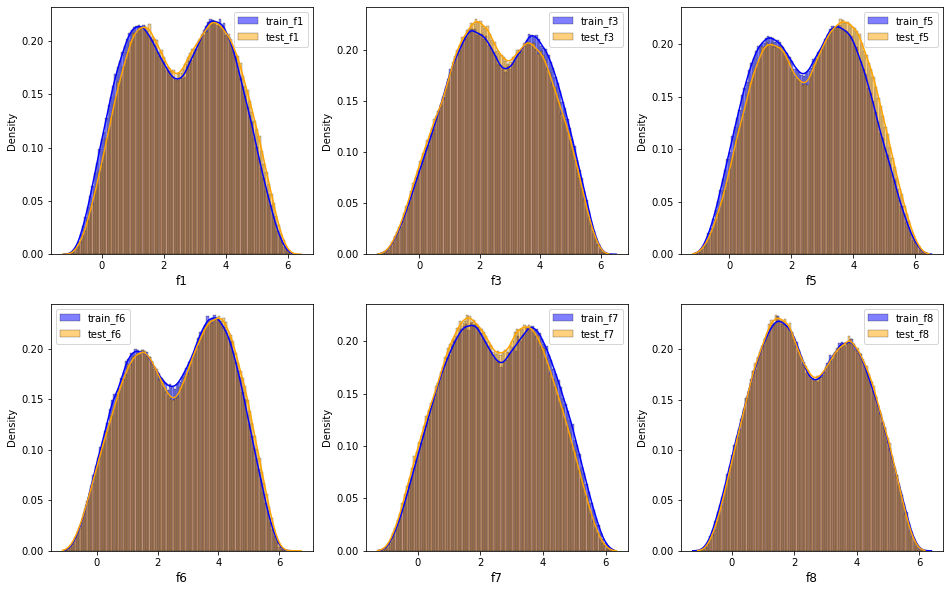

Wall time: 25.2 s


In [16]:
%%time

# plot the bimodal features 
plt.figure()
plt.subplots(2, 3, figsize=(16, 10))
for i, feature in enumerate(bimodal_features[:6], start = 1):
    plt.subplot(2, 3, i)
    plt.gca().set_aspect('auto')
    sns.histplot(train[feature], color="blue", kde=True, stat = 'density', bins=100, label='train_'+feature)
    sns.histplot(test[feature], color="orange", kde=True, stat = 'density', bins=100, label='test_'+feature)
    plt.xlabel(feature, fontsize=12); plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

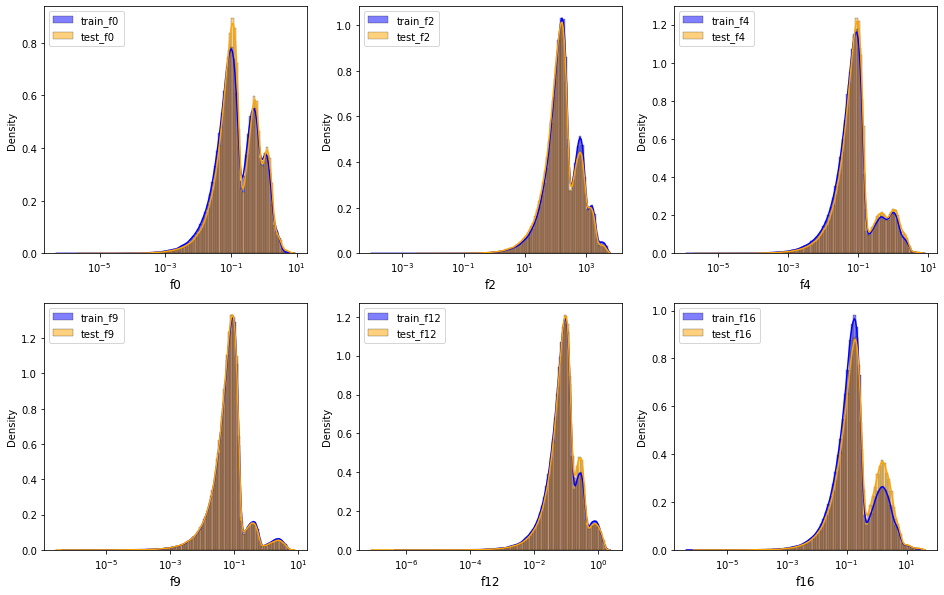

Wall time: 34.6 s


In [17]:
%%time

# plot the skewed features 
plt.figure()
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for i, feature in enumerate(skewed_features[:6], start = 1):
    plt.subplot(2, 3, i)
    plt.gca().set_aspect('auto')
    sns.histplot(train[feature], color="blue", log_scale = True, kde=True, stat = 'density', bins=100, label='train_'+feature)
    sns.histplot(test[feature], color="orange", log_scale = True,  kde=True, stat = 'density', bins=100, label='test_'+feature)
    plt.xlabel(feature, fontsize=12); plt.legend()
plt.show()

# 4. Baseline

In this section, we do a simple prediction using XGBoost with boosted linear models.

In [18]:
# Scoring/Training Baseline Function
def train_model(sklearn_model):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['target'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx].to_numpy(), train['target'].iloc[train_idx].to_numpy()
        X_valid, y_valid = train[features].iloc[valid_idx].to_numpy(), train['target'].iloc[valid_idx].to_numpy()
        X_test = test[features]
        
        # Create model
        model = clone(sklearn_model)
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = model.predict_proba(X_valid)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1] / NUM_FOLDS
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_auc = roc_auc_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} (AUC): {round(fold_auc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_auc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage AUC:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return scores, test_preds, oof_preds

In [19]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        booster = 'gblinear',
        eval_metric = 'auc',
        random_state = RANDOM_SEED
    ),
)

In [20]:
xgb_scores, xgb_preds, xgb_oof = train_model(xgb_pipeline)


Fold 0 (AUC): 0.74908 in 9.37s.
Fold 1 (AUC): 0.75015 in 10.24s.
Fold 2 (AUC): 0.7477 in 9.29s.
Fold 3 (AUC): 0.7499 in 9.59s.
Fold 4 (AUC): 0.74832 in 9.46s.

Average AUC: 0.74903
Training Time: 47.96s
